# 설정

In [15]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "Boosting"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# 부스팅

<b>부스팅</b><sup>boosting</sup>(원래는 <b>가설 부스팅</b><sup>hypothesis boosting</sup>이라 불렀다)은 <b>약한 학습기</b><sup>weak learner</sup>라고도 하는 매우 간단한 분류기를 순차적으로 구축하여 강한 학습기를 만드는 앙상블 방법을 말한다. 이 약한 학습기는 랜덤 추측보다 조금 성능이 좋을 뿐이며 전형적인 예로는 깊이가 1인 결정 트리를 들 수 있다. 부스팅의 핵심 아이디어는 분류하기 어려운 훈련 샘플에 초점을 맞추는 것이다. 즉, 잘못 분류된 훈련 샘플을 그다음 약한 학습기가 학습하여 앙상블 성능을 향상시킨다.

이어지는 절에서 일반적인 부스팅 알고리즘의 절차를 소개하고 가장 인기 있는 구현인 <b>에이다부스트</b><sup>AdaBoost</sup>(adaptive boosting의 줄임말)를 소개해보겠다.

## 부스팅 작동 원리

배깅과는 달리 부스팅의 초창기 방법은 중복을 허용하지 않고 훈련 세트에서 랜덤 샘플을 추출하여 부분 집합을 구성한다. 원본 부스팅 과정은 다음 네 개의 주요 단계로 요약할 수 있다.

<ol>
    <li>훈련 세트 $D$에서 중복을 허용하지 않고 랜덤한 부분 집합 $d_1$을 뽑아 약한 학습기 $C_1$을 훈련한다.</li>
    <li>훈련 세트에서 중복을 허용하지 않고 두 번째 랜덤한 훈련 부분 집합 $d_2$를 뽑고 이전에 잘못 분류된 샘플의 50%를 더해서 약한 학습기 $C_2$를 훈련한다.</li>
    <li>훈련 세트 $D$에서 $C_1$과 $C_2$에서 잘못 분류한 훈련 샘플 $d_3$를 찾아 세 번째 약한 학습기인 $C_3$를 훈련한다.</li>
    <li>약한 학습기 $C_1$, $C_2$, $C_3$를 다수결 투표로 연결한다.</li>
</ol>

각 단계에서 새로운 learner를 학습하여 이전 단계의 base learner의 단점을 보완한다.

레오 브레이만이 언급한 것처럼 부스팅은 배깅 모델에 비해 분산은 물론 편향도 감소시킬 수 있다. 실제로는 에이다부스트 같은 부스팅 알고리즘이 분산이 높다고 알려져 있다. 즉, 훈련 데이터에 과대적합되는 경향이 있다.

## 에이다부스트

<b>Algorithm</b>
<ol>
    <li>Set $\mathrm{W}_i = \frac{1}{n},\, i = 1, 2, ..., n$(impose equal weight initially</li>
    <li>For $j=1$ to m (m = number of classifiers)
        <ol>
            <li>Find $h_j(x)$ that minimizes $L_j$(weighted loss function)<br>
                $L_j = \frac{\sum_{i=1}^{n}\mathrm{W}_iI(y_i\neq h_i(x))}{\sum_{i=1}^n}$</li>
            <li>Defind the weight of classifier: $\alpha_j = log(\frac{1-L_j}{L_j})$</li>
            <li>Update weight: $\mathrm{W}_i:=\mathrm{W}_i\text{exp}(\alpha_jI(y_i\neq h_i(x)),\,i=1, 2, ..., n$</li>
        </ol>
        endfor
    </li>
    <li>Final boosted model: $h(x) = \text{sign}[\sum_{i=1}^m\alpha_jh_j(x)]$

여기서 언급한 원본 부스팅 방법과는 다르게 에이다부스트는 약한 학습기를 훈련할 때 훈련 세트 전체를 사용한다. 훈련 샘플은 반복마다 가중치가 다시 부여되며 이 앙상블은 이전 학습기의 실수를 학습하는 강력한 분류기를 만든다. 에이다부스트 알고리즘을 구체적으로 깊게 알아보기 전에 [그림 1]로 에이다부스트의 기본 개념을 좀 더 잘 이해해 보겠다.

<b>그림 1</b> 에이다부스트
<div style="text-align:center;">
    <img src="./images/Boosting/에이다부스트.png">
</div>

이 에이다부스트 예시를 하나씩 따라가 보자. 그림 1-1은 이진 분류를 위한 훈련 세트를 보여준다. 여기서 모든 샘플은 동일한 가중치를 가진다. 이 훈련 세트를 바탕으로 깊이가 1인 결정 트리(파선)를 훈련하여 샘플을 두 개의 클래스(삼각형과 원)로 나눈다. 물론 가능한 비용 함수(또는 결정 트리 앙상블일 경우 불순도 점수)를 최소화하는 트리를 훈련한다.

다음 단계 그림 1-2에서 이전에 잘못 분류된 샘플 두 개(원)에 큰 가중치를 부여한다. 또 옳게 분류된 샘플의 가중치는 낮춘다. 다음 결정 트리는 가장 큰 가중치를 가진 훈련 샘플에 더 집중할 것이다. 아마도 이런 훈련 샘플은 분류하기 어려운 샘플일 것이다. 그림 1-2에 있는 약한 학습기는 세 개의 원 모양 샘플을 잘못 분류한다. 그림 1-3에서 이 샘플들에 큰 가중치가 부여된다.

이 에이다부스트 앙상블이 세 번의 부스팅 단계만을 가진다고 가정하면 그림 1-4에서처럼 서로 다른 가중치가 부여된 훈련 세트에서 훈련된 세 개의 약한 학습기를 다수결 투표 방식으로 합친다.

이제 의사 코드를 사용하여 자세히 알고리즘을 살펴보자. 여기서 곱셈 기호($\times$)는 원소별 곱셈을 말하고 점 기호($\cdot$)는 두 벡터 사이의 점곱을 의미한다.

<ol>
    <li>가중치 벡터 $\mathrm{w}$를 동일한 가중치로 설정한다. $\sum_i\mathrm{w}_i = 1$</li>
    <li>$m$번 부스팅 반복의 $j$번째에서 다음을 수행한다.
        <ol>
            <li>가중치가 부여된 약한 학습기를 훈련한다. $C_j = \text{train}(\mathrm{X, y, w})$</li>
            <li>클래스 레이블을 예측한다. $\hat{y} = \text{predict}(C_j, \mathrm{X})$</li>
            <li>가중치가 적용된 에러율을 계산한다. $\varepsilon = \mathrm{w}\cdot(\hat{y}\neq y)$</li>
            <li>학습기 가중치를 계산한다. $\alpha_j = 0.5log\frac{1-\varepsilon}{\varepsilon}$</li>
            <li>가중치를 업데이트한다. $\mathrm{w}:=\mathrm{w}\, \times\,\text{exp}(-\alpha_j\,\times\,\hat{y}\,\times\,y)$</li>
            <li>합이 1이 되도록 가중치를 정규화한다. $\mathrm{w}:=\frac{\mathrm{w}}{\sum_i\mathrm{w}_i}$</li>
        </ol></li>
    <li>최종 예측을 계산한다. $\hat{y} = (\sum_{j=1}^m(\alpha_j\,\times\,\text{predict}(C_j, \mathrm{X})) > 0)$

단계 2-C에서 $(\hat{y}\neq y)$ 표현은 1 또는 0으로 구성된 이진 벡터를 의미한다. 예측이 잘못되면 1이고 그렇지 않으면 0이다.

에이다부스트 알고리즘이 간단해 보이지만, [그림 2]의 표와 같이 열 개의 훈련 샘플로 구성된 훈련 세트를 사용하여 구체적인 예제를 살펴보겠다.

<b>그림 2</b> 열 개의 훈련 샘플로 구성된 훈련 세트
<div style="text-align:center;">
    <img src="./images/Boosting/열 개의 훈련 샘플.jpg">
</div>

이 표의 첫 번째 열은 1에서 10까지 훈련 샘플의 인덱스를 나타낸다. 두 번째 열에 각 샘플의 특성 값이 있다. 이 데이터는 1차원 데이터셋이다. 세 번째 열은 각 훈련 샘플 $x_i$에 대한 진짜 클래스 레이블 $y_i$이다. 여기서 $y_i\in\left\{1,\,-1 \right\}$이다. 네 번째 열은 초기 가중치를 보여준다. 초기에 가중치를 동일하게 초기화한다(같은 상수 값을 할당한다). 그다음 합이 1이 되도록 정규화한다. 샘플이 열 개인 훈련 세트에서는 가중치 벡터 $\mathrm{w}$에 있는 각 가중치를 $\mathrm{w}_i$를 0.1로 할당한다. 예측 클래스 레이블 $\hat{y}$는 다섯 번째 열에 나와 있다. 분할 기준은 $x\leq3.0$이라고 가정한다. 표의 마지막 열은 의사 코드에서 정의한 업데이트 규칙에 의해 업데이트된 가중치를 보여 준다.

가중치 계산 공식이 처음에는 조금 복잡해 보일 수 있으므로 단계별로 계산을 수행해 보겠다. 단계 2-C에 나와 있는 가중치된 에러율 $\varepsilon$를 먼저 계산해 보자.

$$
\begin{align*}
\varepsilon &= 0.1\times0+0.1\times0+0.1\times0+0.1\times0+0.1\times0+0.1\times0+0.1\times1+0.1\times1+0.1\times1+0.1\times 0\\
 &= \frac{3}{10}\\
 &= 0.3
\end{align*}
$$

그다음 단계 2-D에 나오는 학습기 가중치 $\alpha_j$를 계산한다. 나중에 단계 2-E에서 가중치를 업데이트할 때와 단계 3에서 다수결 투표 예측을 위한 가중치에 사용된다.

$$
\alpha_j = 0.5log(\frac{1-\varepsilon}{\varepsilon})\approx0.424
$$

학습기 가중치 $\alpha_j$를 계산한 후 다음 식을 사용하여 가중치 벡터를 업데이트할 수 있다.

$$
\mathrm{w}:= \mathrm{w}\,\times\,\text{exp}(-\alpha_j\,\times\,\hat{y}\,\times\,y)
$$

여기서 $\hat{y}\,\times\,y$는 예측 클래스 레이블 벡터와 진짜 클래스 레이블 벡터 사이의 원소별 곱셈이다. 예측 $\hat{y}_i$가 맞으면 $\hat{y}_i\,\times\,y_i$는 양의 값이 되고 $\alpha_j$도 양의 값이기 때문에 $i$번째 가중치가 감소한다.<sup><a id="a01" href="#p01">[1]</a></sup>

$$
0.1\times\text{exp}(-0.424\times1\times1)\approx 0.065
$$

비슷하게 예측 레이블 $\hat{y}_i$가 맞지 않으면 $i$번째 가중치가 다음과 같이 증가한다.

$$
0.1\times\text{exp}(-0.424\times1\times(-1))\approx0.153
$$

또는 다음과 같다.

$$
0.1\times\text{exp}(-0.424\times(-1)\times1)\approx0.153
$$

가중치 벡터의 각 가중치를 업데이트하고 난 후 가중치의 합이 1이 되도록 정규화한다(단계 2-F).

$$
\mathrm{w}:=\frac{\mathrm{w}}{\sum_i\mathrm{w}_i}
$$

여기서 $\sum_i\mathrm{w}_i = 7\times0.065+3\times0.153 = 0.914$이다.

옳게 분류된 샘플에 대응하는 가중치는 다음 부스팅 단계에서 초깃값 0.1보다 $0.065 / 0.914 \approx0.072$로 감소된다. 비슷하게 잘못 분류된 샘플의 가중치는 0.1에서 $0.153/0.914\approx0.167$로 증가한다.

다음은 moons 데이터셋에 훈련시킨 다섯 개의 연속된 예측기의 결정 경계다(이 모델은 규제를 강하게 한 RBF 커널 SVM 분류기다<sup><a id="a02" href="#p02">[2]</a></sup>). 첫 번재 분류기가 많은 샘플을 잘못 분류해서 이 샘플들의 가중치가 높아졌다. 따라서 두 번째 분류기는 이 샘플들을 더 정확히 예측하게 된다. 오른쪽 그래프는 학습률을 반으로 낮춘 것만 빼고 똑같은 일련의 예측기를 나타낸 것이다(즉, 잘못 분류된 샘플의 가중치는 반복마다 절반 정도만 높아진다). 그림에서 볼 수 있듯이 이런 연속된 학습 기법은 경사 하강법과 비슷한 면이 있다. 경사 하강법은 비용 함수를 최소화하기 위해 한 예측기의 모델 파라미터를 조정해가는 반면 에이다부스트는 점차 더 좋아지도록 앙상블에 예측기를 추가한다.

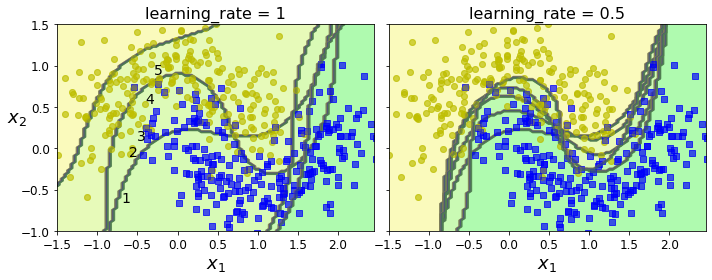

In [16]:
from sklearn.svm import SVC

m = len(X_train)

fig, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)
for subplot, learning_rate in ((0, 1), (1, 0.5)):
    sample_weights = np.ones(m) / m
    plt.sca(axes[subplot])
    for i in range(5):
        svm_clf = SVC(kernel="rbf", C=0.2, gamma=0.6, random_state=42)
        svm_clf.fit(X_train, y_train, sample_weight=sample_weights * m)
        y_pred = svm_clf.predict(X_train)
        r = sample_weights[y_pred != y_train].sum() / sample_weights.sum() # equation 7-1
        alpha = learning_rate * np.log((1 - r) / r) # equation 7-2
        sample_weights[y_pred != y_train] *= np.exp(alpha) # equation 7-3
        sample_weights /= sample_weights.sum() # normalization step
        plot_decision_boundary(svm_clf, X, y, alpha=0.2)
        plt.title("learning_rate = {}".format(learning_rate), fontsize=16)
    if subplot == 0:
        plt.text(-0.7, -0.65, "1", fontsize=14)
        plt.text(-0.6, -0.10, "2", fontsize=14)
        plt.text(-0.5,  0.10, "3", fontsize=14)
        plt.text(-0.4,  0.55, "4", fontsize=14)
        plt.text(-0.3,  0.90, "5", fontsize=14)
    else:
        plt.ylabel("")

save_fig("boosting_plot")
plt.show()

### 사이킷런에서 에이다부스트 사용

이전 절에서 에디아부스트를 간략하게 소개했다. 이제 실제 사용하는 부분으로 넘어가서 사이킷런으로 에이다부스트 앙상블 분류기를 훈련시켜 보자. base_estimator 속성으로 깊이가 1인 결정 트리를 전달하여 트리 500개로 구성된 AdaBoostClassifier를 훈련시키겠다.

In [17]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

tree = DecisionTreeClassifier(criterion='entropy',
                              random_state=42,
                              max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree,
                         n_estimators=500,
                         learning_rate=0.5,
                         algorithm="SAMME.R",
                         random_state=42)
tree = tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
y_test_pred = tree.predict(X_test)
tree_train = accuracy_score(y_train, y_train_pred)
tree_test = accuracy_score(y_test, y_test_pred)
print('결정 트리의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (tree_train, tree_test))

결정 트리의 훈련 정확도/테스트 정확도 0.819/0.824


여기서 보듯이 깊이가 1인 결정 트리는 훈련 데이터에 과소적합된 것 같다.

In [18]:
ada = ada.fit(X_train, y_train)
y_train_pred = ada.predict(X_train)
y_test_pred = ada.predict(X_test)
ada_train = accuracy_score(y_train, y_train_pred)
ada_test = accuracy_score(y_test, y_test_pred)
print('에이다부스트의 훈련 정확도/테스트 정확도 %.3f/%.3f'
      % (ada_train, ada_test))

에이다부스트의 훈련 정확도/테스트 정확도 0.995/0.880


에이다부스트 모델은 훈련 세트의 모든 클래스 레이블을 거의 정확하게 예측하고 깊이가 1인 결정 트리에 비해 테스트 성능도 좀 더 높다. 훈련 성능과 테스트 성능 사이에 간격이 크므로 모델의 편향을 줄임으로써 추가적인 분산이 발생했다.

예시를 위해 간단한 예제를 사용했지만 에이다부스트 분류기의 성능이 깊이가 1인 결정 트리에 비해 좀 더 향상되었다. 테스트 세트를 반복적으로 사용하여 모델을 선택하는 것은 나쁜 방법이다. 이는 일반화 성능을 매우 낙관적으로 추정하기 때문이다.

끝으로 결정 영역의 모습을 확인해보자.

In [19]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
    DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5, random_state=42)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200, random_state=42)

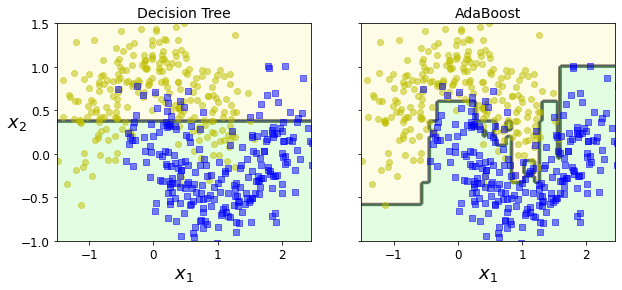

In [20]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0', '#9898ff', '#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58', '#4c4c7f', '#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree, X, y)
plt.title("Decision Tree", fontsize=14)
plt.sca(axes[1])
plot_decision_boundary(ada_clf, X, y)
plt.title("AdaBoost", fontsize=14)
plt.ylabel("")
plt.show()

사이킷런은 SAMME<sup><a id="a02" href="#p02">[2]</a></sup>라는 에이다부스트의 다중 클래스 버전을 사용한다. 클래스가 두 개뿐일 때는 SAMME가 에이다부스트와 동일하다.<sup><a id="a03" href="#p03">[3]</a></sup> 예측기가 클래스의 확률을 추정할 수 있다면(즉, <code>predict_proba()</code> 메서드가 있다면) 사이킷런은 SAMME.R(끝의 R은 'Real'을 말한다)이라는 SAMME의 변종을 사용한다. 이 알고리즘은 예측값 대신 클래스 확률에 기반하며 일반적으로 성능이 더 좋다.<sup><a id="a04" href="#p04">[4]</a></sup>

AdaBoostClassifier의 회귀 버전인 AdaBoostRegressor도 있다.<sup><a id="a05" href="#p05">[5]</a></sup>

<b>TIP</b> 에이다부스트 앙상블이 훈련 세트에 과대적합되면 추정기 수를 줄이거나 추정기의 규제를 더 강하게 해보자.

## 그레디언트 부스팅

<b>Algorithm</b>
<ol>
    <li>Initialize $f_0(x) = \underset{\gamma}{\text{argmin}}\sum_{i=1}^NL(y_i, \gamma)$</li>
    <li> For $m = 1$ to M:
        <ol>
            <li>For $i = 1, ..., N$ compute<br>
               $r_{im} = -[\frac{\partial L(y_i, f(x_i))}{\partial f(x_i)}],\, f(x_i) = f_{m-1}(x_i)$</li>
            <li>Fit a regression tree to the targets $r_{im}$ giving terminal regions<br>
                $R_{jm},\,j=1, ..., J_m$</li>
            <li>For $j = 1, ..., J_m$ compute<br>
                $\gamma_{jm} = \underset{\gamma}{\text{argmin}}\sum_{x_i\in R_{jm}}L(y_i, f_{m-1}(x_i) + \gamma)$</li>
            <li>Update $f_m(x) = f_{m-1}(x) + \sum_{j=1}^{J_m}\gamma_{jm}I(x\in R_{jm})$</li>
        </ol>
    <li>Output $\hat{f}(x) = f_m(x)$</li>
</ol>

<b>GBM</b><sup>Gradient Boost Machine</sup>은 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가하는 점은 유사하나, 가중치 업데이트를 경사 하강법<sup>Gradient Boosting</sup>을 이용하는 것이 큰 차이다. 즉 에이다부스트처럼 반복마다 샘플의 가중치를 수정하는 대신 이전 예측기가 만든 <b>잔여 오차</b><sup>residual error</sup>에 새로운 예측기를 학습시킨다. 잔여 오차 값은 실제 값 - 예측값이다. 분류의 실제 결괏값을 $y$, 피처를 $x_1, x_2, \cdots, x_n$, 그리고 이 피처에 기반한 예측 함수를 $F(x)$ 함수라고 하면 오류식 $h(x) = y - F(x)$이 된다. 이 오류식 $h(x) = y - F(x)$를 최소화하는 방향성을 가지고 반복적으로 가중치 값을 업데이트 하는 것이 경사 하강법이다. 이 경사 하강법은 머신러닝에서 중요한 기법 중 하나다.

<b>Why gradient?</b>

다음은 회귀 식의 비용함수 식이다.

$$
L = \frac{1}{2}\sum_{i=1}^n\left\{y_i - f(x_i)\right\}^2
$$

이 식을 미분하면 다음과 같다.

$$
\frac{\partial L}{\partial f(x_i)} = - \left\{y_i - f(x_i)\right\}
$$

여기서 $y_i - f(x_i)$는 잔차와 같다는 것을 알 수 있다. 위 식을 정리해서 다시 써보면,

$$
y_i - f(x_i) = - \frac{\partial L}{\partial f(x_i)}
$$

즉, Residual = Negative Gradient 라는 식이 완성된다.

기본적으로 그레디언트 부스팅 트리는 보통 하나에서 다섯 정도의 깊지 않은 트리를 사용하므로 메모리를 적게 사용하고 예측도 빠르다. 그레디언트 부스팅 트리는 머신러닝 경연 대회에서 우승을 많이 차지했고 업계에서도 널리 사용한다. 랜덤 포레스트보다는 매개변수 설정에 조금 더 민감하지만 잘 조정하면 더 높은 정확도를 제공해준다.

결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제를 풀어보겠다(당연히 그레디언트 부스팅은 분류 문제에도 아주 잘 작동한다). 이를 <b>그레디언트 트리 부스팅</b><sup>gradient tree boosting</sup> 또는 <b>그레디언트 부스티드 회귀 트리</b><sup>gradient boosted regression tree</sup>(GBRT)라고 한다. 먼저 DecisionTreeRegressor를 훈련 세트(잡음이 섞인 2차 곡선 형태의 훈련 세트)에 학습시켜보겠다.

In [21]:
from sklearn.tree import DecisionTreeRegressor

# 간단한 이차식 형태의 데이터셋
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3 * X[:, 0]**2 + 0.05 * np.random.randn(100)

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시킨다.

In [22]:
y2 = y - tree_reg1.predict(X)
tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

그런 다음 두 번째 예측기가 만든 잔여 오차에 세 번재 회귀 모델을 훈련시킨다.

In [23]:
y3 = y2 - tree_reg2.predict(X)
tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 세 개의 트리를 포함하는 앙상블 모델이 생겼다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 된다.

In [24]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

다음 그림의 왼쪽 열은 이 세 트리의 예측이고 오른쪽 열은 앙상블의 예측이다. 첫 번째 행에서는 앙상블에 트리가 하나만 있어서 첫 번째 트리의 예측과 완전히 같다. 두 번째 행에서는 새로운 트리가 첫 번째 트리의 잔여 오차에 대해 학습되었다. 오른쪽의 앙상블 예측이 두 개의 트리 예측의 합과 같은 것을 볼 수 있다. 비슷하게 세 번째 행에서는 또 다른 트리가 두 번째 트리의 잔여 오차에 훈련되었다. 트리가 앙상블에 추가될수록 앙상블의 예측이 점차 좋아지는 것을 알 수 있다.

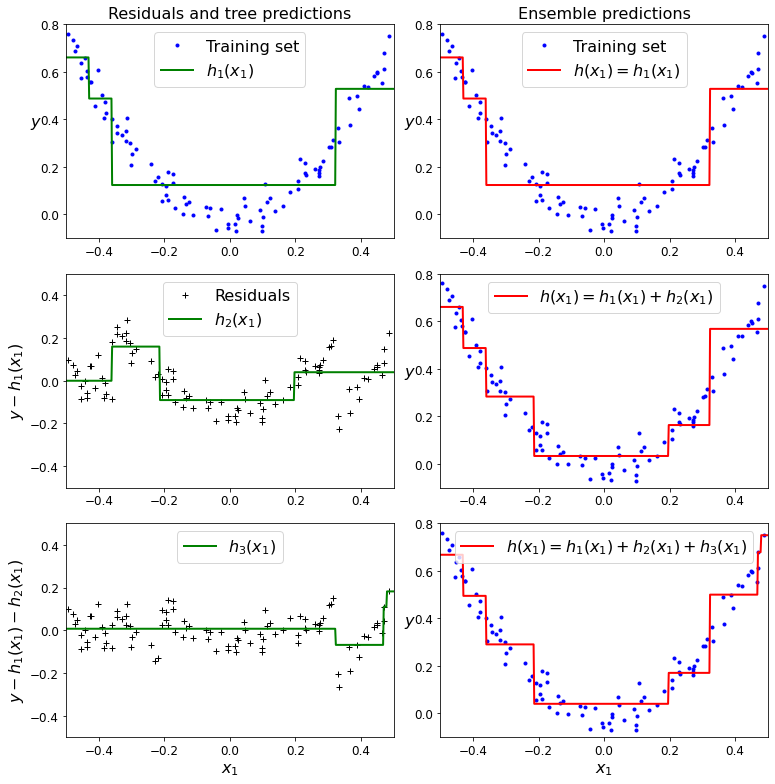

In [25]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)
    
plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()

사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있다. 트리 수(n_estimators)와 같이 앙상블의 훈련을 제어하는 매개변수는 물론 RandomForestRegressor와 아주 비슷하게 결정 트리의 성장을 제어하는 매개변수(max_depth, min_samples_leaf)를 가지고 있다. 다음은 이전에 만든 것과 같은 앙상블을 만드는 코드다.

In [26]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3,
                          random_state=42)

그렇지 않은 경우도 있겠지만, 일반적으로 GBM이 랜덤 포레스트보다는 예측 성능이 조금 뛰어난 경우가 많다. 그러나 수행 시간이 오래 걸리고, 하이퍼 파라미터 튜닝 노력도 더 필요하다. 특히 수행 시간 문제는 GBM이 극복해야 할 중요한 과제다. 사이킷런의 GradientBoostingClassifier는 약한 학습기의 순차적인 예측 오류 보정을 통해 학습을 수행하므로 멀티 CPU 코어 시스템을 사용하더라도 병렬 처리가 지원되지 않아서 대용량 데이터의 경우 학습에 매우 많은 시간이 필요하다. 반면에 랜덤 포레스트의 경우 상대적으로 빠른 수행 시간을 보장해주기 때문에 더 쉽게 예측 결과를 도출할 수 있다.

### GBM 하이퍼 파라미터

<ul>
    <li><b>loss:</b> 경사 하강법에서 사용할 비용 함수를 지정한다. 특별한 이유가 없으면 기본값인 'deviance'를 그대로 적용한다. 에이다부스트에서 사용하는 'exponential'도 있다. GradientBoostingRegressor의 loss 매개변수 옵션은 최소제곱을 의미하는 'ls'가 기본값이고 최소 절댓값 오차인 'lad', 후버 손실 함수인 'huber', 사분위수 손실 함수인 'quantile'이 있다.</li>
    <li><b>learning_rate:</b> GBM이 학습을 진행할 때마다 적용할 학습률이다. Weak learner가 순차적인 오류 값을 보정해 나가는 데 적용하는 계수다. 0 ~ 1 사이의 값을 지정할 수 있으며 기본값은 0.1이다. 너무 작은 값을 적용하면 업데이트되는 값이 작아져서 최소 오류 값을 찾아 예측 성능이 높아질 가능성이 높다. 이는 <b>축소</b><sup>shrinkage</sup>라고 부르는 규제 방법이다. 하지만 많은 weak learner는 순차적인 반복이 필요해서 수행 시간이 오래 걸리고, 또 너무 작게 설정하면 모든 weak learner의 반복이 완료돼도 최소 오류 값을 찾지 못할 수 있다. 반대로 큰 값을 적용하면 최소 오류 값을 찾지 못하고 그냥 지나쳐 버려 예측 성능이 떨어질 가능성이 높아지지만, 빠른 수행이 가능하다. 이러한 특성 때문에 learning_rate는 n_estimators와 상호 보완적으로 조합해 사용한다. learning_rate를 작게 하고 n_estimators를 크게 하면 더 이상 성능이 좋아지지 않는 한계점까지는 예측 성능이 조금씩 좋아질 수 있다. 하지만 수행 시간이 너무 오래 걸리는 단점이 있으며, 예측 성능 역시 현격히 좋아지지는 않는다.</li>
    <li><b>n_estimators:</b> weak learner의 개수다. weak learner가 순차적으로 오류를 보정하므로 개수가 많을수록 예측 성능이 일정 수준까지는 좋아질 수 있다. 하지만 개수가 많을수록 수행 시간이 오래 걸린다. 기본값은 100이다.</li>
    <li><b>subsample:</b> weak learner가 학습에 사용하는 데이터의 샘플링 비율이다. 기본값은 1이며, 이는 전체 학습 데이터를 기반으로 학습한다는 의미다(0.5이면 학습 데이터의 50%). 과대적합이 염려되는 경우 subsample을 1보다 작은 값으로 설정한다. 예를 들어 subsample=0.25라고 하면 각 트리는 무작위로 선택된 25%의 훈련 샘플로 학습된다. 이는 편향이 높아지는 대신 분산이 낮아지게 된다. 또한 훈련 속도를 상당히 높인다. 이런 기법을 <b>확률적 그레디언트 부스팅</b><sup>stochastic gradient boosting</sup>이라고 한다.</li>
</ul>

다음 그림은 작은 학습률로 훈련시킨 두 개의 GBRT 앙상블을 보여준다. 왼쪽은 훈련 세트를 학습하기에는 트리가 충분하지 않은 반면 오른쪽은 트리가 너무 많아 훈련 세트에 과대적합되었다.

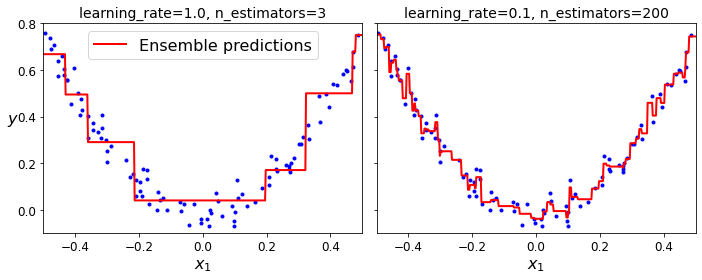

In [27]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

최적의 트리 수를 찾기 위해서는 조기 종료 기법을 사용할 수 있다. 간단하게 구현하려면 <code>staged_predict()</code> 메서드를 사용한다. 이 메서드는 훈련의 각 단계(트리 하나, 트리 두 개 등)에서 앙상블에 의해 만들어진 에측기를 순회하는 반복자<sup>iterator</sup>를 반환한다. 다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정한다. 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킨다.

In [28]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=49)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120, random_state=42)
gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_val, y_pred)
          for y_pred in gbrt.staged_predict(X_val)]
bst_n_estimators = np.argmin(errors) + 1

gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators, random_state=42)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=56, random_state=42)

In [29]:
min_error = np.min(errors)

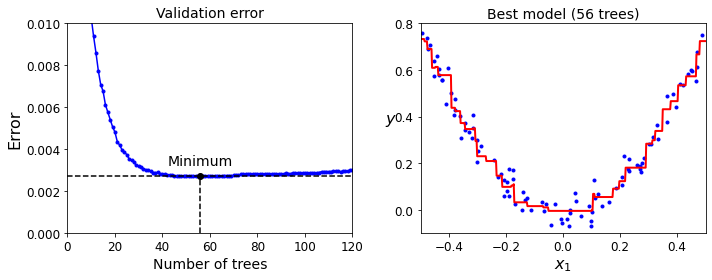

In [30]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.plot(np.arange(1, len(errors) + 1), errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(bst_n_estimators, min_error, "ko")
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

(많은 수의 트리를 먼저 훈련시키고 최적의 수를 찾기 위해 살펴보는 대신) 실제로 훈련을 중지하는 방법으로 조기 종료를 구현할 수도 있다. warm_start=True로 설정하면 사이킷런이 <code>fit()</code> 메서드가 호출될 때 기존 트리를 유지하고 훈련을 추가할 수 있도록 해준다. 다음 코드는 연속해서 다섯 번의 반복 동안 검증 오차가 향상되지 않으면 훈련을 멈춘다.<sup><a id="a06" href="#p06">[6]</a></sup>

In [31]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            break # early stopping

In [32]:
print(gbrt.n_estimators)

61


In [33]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.002712853325235463


비슷한 종류의 데이터에서 그레디언트 부스팅과 랜덤 포레스트 둘 다 잘 작동하지만, 보통 더 안정적인 랜덤 포레스트를 먼저 적용하곤 한다. 랜덤 포레스트가 잘 작동하더라도 예측 시간이 중요하거나 머신러닝 모델에서 마지막 성능까지 쥐어짜야 할 때 그레디언트 부스팅을 사용하면 도움이 된다.

# 미주

<b id="p01">1</b> 약한 학습기가 무작위 추측보다 좋다고($\varepsilon<0.5$) 가정하기 때문에 $a_j$는 양수로 생각한다. 실전 구현에서는 예측이 맞은 샘플의 가중치는 업데이트하지 않는다. [↩](#a01)

<b id="p02">2</b> stagewise additive modeling using a multiclass exponential loss function의 약자다. [↩](#a02)

<b id="p03">3</b> SAMME 알고리즘에서 예측기 가중치를 구하는 식은 다음과 같다.
$$
\alpha_j = \eta(log\frac{1-r_j}{r_j}+log(K-1))
$$
클래스의 개수 $K$가 2면 에이다부스트 알고리즘의 식과 동일하다. [↩](#a03)

<b id="p04">4</b> SAMME.R 알고리즘에서 예측기 가중치를 구하는 식은 다음과 같다.
$$
\alpha_j = -\eta\frac{K-1}{K}ylog\hat{y}_j
$$
여기에서 $y$는 정답 클래스일 때 1 아니면 $-\frac{1}{1-K}$이고, $\hat{y}_j$는 $j$번째 예측기가 만든 클래스 확률이다. 예측을 할 때는 다음 공식으로 예측기별 클래스 확률을 계산해서 합한 후 확률이 가장 높은 클래스를 선택한다.
$$
\hat{y}(x) = \underset{k}{\text{argmax}}\sum_{j=1}^N(K-1)(log\hat{y}_i - \frac{1}{K}\sum_{k=0}^K\hat{y}_j)
$$
AdaBoostClassifier의 algoritm 매개변수의 기본값은 'SAMME.R'이다. SAMME 알고리즘을 사용하려면 algorithm='SAMME'로 지정한다. [↩](#a04)

<b id="p05">5</b> AdaBoostRegressor는 AdaBoost.R2 알고리즘을 사용한다. 예측기의 신뢰도 $\beta_j = \frac{L_j}{1 - L_j}$를 $L_j = \sum_{i=1}^{m}\mathrm{w}^{(i)}\mathrm{v}_j$로 계산한다. 여기서 $\mathrm{v}_j$는 예측기가 만드는 평균 오차며, AdaBoostRegressor의 loss 매개변수가 기본값인 'linear'일 때는 $\frac{|\hat{y}-y|}{|\hat{y} - y|_{\text{max}}}$이고 'square'일 때는 $\mathrm{v}_{\text{linear}}^2$, 'exponential'일 때는 $1 - e^{\mathrm{v}_{\text{linear}}}$이다. 예측기의 가중치는 $\alpha_j = \eta\,log(\frac{1}{\beta})$로 계산하고, 샘플의 가중치는 $\mathrm{w}^{(i)} = \mathrm{w}^{(i)}\beta^{(1-\mathrm{v}_j)\eta}$와 같이 업데이트한다. 예측을 할 땐 예측기의 결괏값을 순서대로 정렬하여 놓고 각 예측기 가중치의 누적값이 중간이 되는 지점에 있는 예측기의 결과를 사용한다. [↩](#a05)

<b id="p06">6</b> 사이킷런 0.20 버전에서 그래디언트 부스팅에 조기 종료 기능이 추가되었다. 훈련 데이터에서 validation_fraction 비율(기본값 0.1)만큼 떼내어 측정한 손실이 n_iter_no_change 반복 동안에 tol 값(기본값 1e-4) 이상 향상되지 않으면 훈련이 멈춘다. [↩](#a06)